# 📘 Real-Time Age, Gender, and Race Prediction with Multi-Output CNN and OpenCV

> This project demonstrates the development and real-time deployment of a **multi-output Convolutional Neural Network (CNN)** model capable of predicting **age (regression)**, **gender (classification)**, and **race (classification)** from facial images. The model is trained using the **Keras Functional API**, and integrated with **OpenCV** to enable live facial detection via webcam or video feed.  
>  
> The system showcases real-time **human attribute recognition** by combining deep learning and computer vision, enabling practical applications in **smart surveillance**, **interactive systems**, and **demographic analytics**. The model is even capable of recognizing **multiple faces** and detecting faces **shown on phone screens in live video**, demonstrating its robustness and generalization.

> **👤 Author:** *Alden Quiñones*

---

## 1. 📦 Library Imports and Setup

This section prepares the environment by importing all the essential libraries:

- **OpenCV (`cv2`)**: Real-time face detection and video feed handling.
- **NumPy (`numpy`)**: Numerical computations and array operations.
- **Matplotlib & Seaborn**: Visualizing data distributions, confusion matrices, training history.
- **Pandas**: Data manipulation and tabular representation of results.
- **TensorFlow (Keras)**: Model creation, training, and inference.
- **Scikit-learn**: Dataset splitting, metrics, and utilities.
- **Rich**: Displays elegant progress bars during image loading and preprocessing.

---

## 2. ⚙️ Installation Guide

To set up the environment, open **Command Prompt (Windows)** or **Terminal (Linux/macOS)** and install the required packages using `pip`:

```bash
pip install tensorflow opencv-python numpy matplotlib seaborn pandas scikit-learn rich

In [1]:
# -*- coding: utf-8 -*-
# pip install tensorflow opencv-python matplotlib seaborn pandas scikit-learn rich

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from rich.progress import track

## 1. 📂 Load and Preprocess Images

This section loads facial images from the `./UTKFace` dataset. Each image filename encodes the age, gender, and race of the subject. The code processes each image by resizing it to `64x64` pixels and normalizes the pixel values to fall between 0 and 1.

The labels are extracted as follows:
- **Age** is parsed directly as an integer.
- **Gender**: 0 for male, 1 for female.
- **Race**: integer values from 0–4 representing different racial groups.

The gender and race labels are then converted to one-hot encoded vectors, preparing them for classification tasks in the model.



In [2]:
# 1. Load and preprocess images
data_dir = "./UTKFace"
print("Loading and preprocessing images...")
X, age_labels, gender_labels, race_labels = [], [], [], []

file_list = os.listdir(data_dir)
for file in track(file_list, description="Processing images..."):
    try:
        parts = file.split('_')
        age = int(parts[0])
        gender = int(parts[1])  # 0 = male, 1 = female
        race = int(parts[2])    # 0–4
        
        img_path = os.path.join(data_dir, file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64, 64))
        
        X.append(img)
        age_labels.append(age)
        gender_labels.append(gender)
        race_labels.append(race)
    except:
        continue

X = np.array(X, dtype="float32") / 255.0
age_labels = np.array(age_labels)
gender_labels = np.array(gender_labels)
race_labels = np.array(race_labels)

gender_labels_cat = to_categorical(gender_labels, num_classes=2)
race_labels_cat = to_categorical(race_labels, num_classes=5)

Loading and preprocessing images...


Output()

## 2. Visualize Distributions

This part of the code helps visualize the distribution of labels (age, gender, and race) in the dataset using `matplotlib` and `seaborn`. These visualizations are crucial for understanding the dataset's balance or imbalance across different classes, which can impact the model's learning behavior.

 📌 Explanation:
- A horizontal subplot layout with 3 plots is created using `plt.subplots(1, 3)`.
- **Plot 1 (Age Distribution)**: Displays a histogram of age values. Helps determine if the dataset is skewed toward a certain age group.
- **Plot 2 (Gender Distribution)**: Uses a count plot to show how many samples are male vs. female.
- **Plot 3 (Race Distribution)**: Uses a count plot to display how many samples exist per race catg are needed.


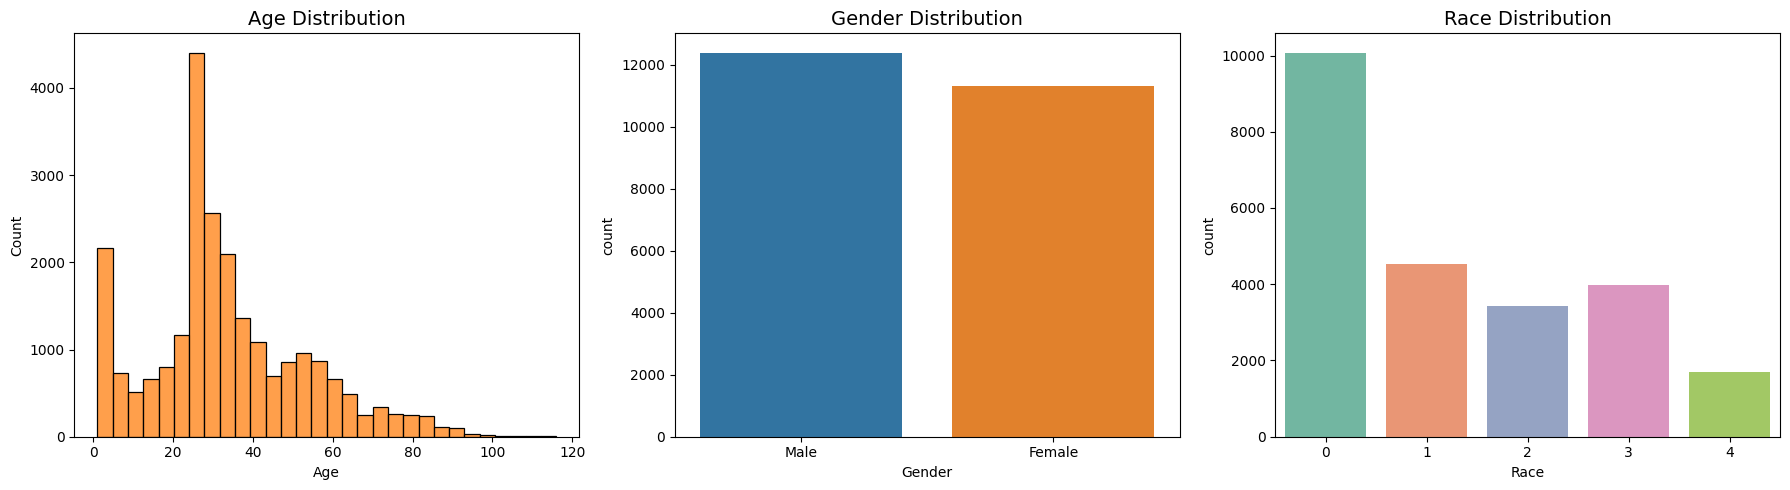

In [4]:
# Define palettes
gender_palette = {'Male': '#1f77b4', 'Female': '#ff7f0e'}
race_palette = sns.color_palette("Set2", 5)

# Create DataFrame for visualization
df = pd.DataFrame({
    'Age': age_labels,
    'Gender': ['Male' if g == 0 else 'Female' for g in gender_labels],
    'Race': race_labels
})

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Age distribution
sns.histplot(data=df, x='Age', bins=30, kde=False, color="#FF7F0E", ax=axes[0])
axes[0].set_title("Age Distribution", fontsize=14)

# Gender distribution
sns.countplot(data=df, x='Gender', hue='Gender', palette=gender_palette, legend=False, ax=axes[1])
axes[1].set_title("Gender Distribution", fontsize=14)

# Race distribution
sns.countplot(data=df, x='Race', hue='Race', palette=race_palette, legend=False, ax=axes[2])
axes[2].set_title("Race Distribution", fontsize=14)

plt.tight_layout()
plt.show()

## 3. 🖼️ Display Sample Images

This section displays a sample of 10 images from the dataset along with their corresponding labels for **age**, **gender**, and **race**. Visual inspection of these images helps validate that the preprocessing and label extraction were performed correctly.

Each subplot includes:
- The actual image (after resizing and normalization).
- A title that indicates:
  - `Age`: the numerical age of the individual.
  - `G`: gender label (0 = male, 1 = female).
  - `R`: race label (0–4 based on dataset definessing is accurate.

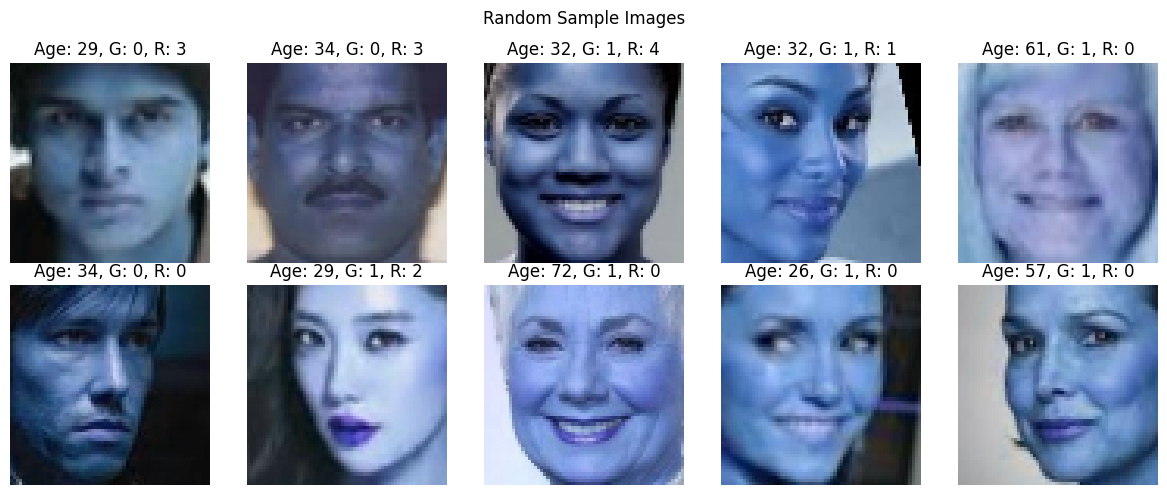

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 3. Display random sample images
num_samples = 10
sample_indices = np.random.choice(len(X), num_samples, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    idx = sample_indices[i]
    ax.imshow(X[idx])
    ax.set_title(f"Age: {age_labels[idx]}, G: {gender_labels[idx]}, R: {race_labels[idx]}")
    ax.axis('off')

plt.suptitle("Random Sample Images")
plt.tight_layout()
plt.show()


## 4. 🧪 Train-Test Split

This section divides the dataset into training and testing sets. The split ensures that the model is trained on one portion of the data and evaluated on a separate, unseen portion to measure generalization performance.

The `train_test_split()` function from `sklearn.model_selection` is used to split the features (`X`) and labels (`age_labels`, `gender_labels_cat`, `race_labels_cat`) into 80% training and 20% testing sets. The `random_state=42` ensures reproducibility — the same data split will occur every time the code runcible results.

In [6]:
# 4. Train-test split
X_train, X_test, age_train, age_test, gender_train, gender_test, race_train, race_test = train_test_split(
    X, age_labels, gender_labels_cat, race_labels_cat, test_size=0.2, random_state=42)

## 5. 🧠 Build Multi-Output Convolutional Neural Network (CNN)

This section defines the core architecture of a Convolutional Neural Network (CNN) designed to perform **multi-output prediction** — simultaneously predicting **age** (regression), **gender** (binary classification), and **race** (multi-class classification).

The model is built using the Keras Functional API, which allows flexible architectures with multiple outputs.

### 📌 Layer Breakdown:

1. **Input Layer**  
   - Shape: `(64, 64, 3)` for 64×64 RGB images.

2. **Conv2D Layer 1**  
   - Applies 32 filters of size 3×3 with ReLU activation.

3. **MaxPooling2D Layer 1**  
   - Reduces spatial dimensions by 2×2.

4. **Conv2D Layer 2**  
   - Applies 64 filters of size 3×3 with ReLU activation.

5. **MaxPooling2D Layer 2**  
   - Further reduces spatial dimensions.

6. **Flatten Layer**  
   - Converts 2D feature maps to a 1D vector for dense layers.

7. **Dense Layer**  
   - A fully connected layer with 128 units and ReLU activation.

8. **Dropout Layer**  
   - Applies 50% dropout to reduce

In [7]:
# 5. Build multi-output CNN
input_layer = Input(shape=(64, 64, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

## 6. Define Output Layers and Compile the Model

This part defines **three output layers** for the CNN model, corresponding to the three tasks:
1. **Age prediction** (regression),
2. **Gender classification** (binary classification), and
3. **Race classification** (multi-class classification).

It then compiles the model using appropriate loss functions and evaluation metrics for each output type
### 📌 Explanation:

- **Output Layers**:
  - `age_output`: Uses a **linear activation** for continuous age prediction. Output shape is `(None, 1)`.
  - `gender_output`: Uses **softmax** over 2 units (Male, Female). Output shape is `(None, 2)`.
  - `race_output`: Uses **softmax** over 5 categories (e.g., White, Black, Asian, Indian, Other). Output shape is `(None, 5)`.

- **Model Definition**:
  - The model is built using the Keras Functional API via `Model(inputs=..., outputs=...)`.
  - It accepts a single input (the processed face image) and returns three outputs.

- **Model Compilation**:
  - **Optimizer**: `adam` – efficient for most deep learning tasks.
  - **Losses**:
    - Age: `'mse'` (Mean Squared Error) for regression.
    - Gender & Race: `'categorical_crossentropy'` for classification.
  - **Metrics**:
    - Age: `'mae'` (Mean Absolute Error) – interpretable in age units.
    - Gender & Race: `'accuracy'`.

- **`model.summary()`**:
  - Displays a summary of the model architecture, including number of trainable simultaneous training of all tasks.

In [8]:
# Output layers
age_output = Dense(1, activation='linear', name='age_output')(x)
gender_output = Dense(2, activation='softmax', name='gender_output')(x)
race_output = Dense(5, activation='softmax', name='race_output')(x)

model = Model(inputs=input_layer, outputs=[age_output, gender_output, race_output])
model.compile(
    optimizer='adam',
    loss={
        'age_output': 'mse',
        'gender_output': 'categorical_crossentropy',
        'race_output': 'categorical_crossentropy'
    },
    metrics={
        'age_output': 'mae',
        'gender_output': 'accuracy',
        'race_output': 'accuracy'
    }
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 62, 62, 32)        │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 31, 31, 32)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 29, 29, 64)        │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 14, 14, 64)        │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 12544)             │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │       1,605,760 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ age_output (Dense)            │ (None, 1)                 │             129 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gender_output (Dense)         │ (None, 2)                 │             258 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ race_output (Dense)           │ (None, 5)                 │             645 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,626,184 (6.20 MB)

 Trainable params: 1,626,184 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Train the Model

This section initiates the training process for the compiled multi-output Convolutional Neural Network. The model is trained to simultaneously predict age (regression), gender (binary classification), and race (multi-class classification) from facial images.

 🧠 Explanation:

The `model.fit()` function is used to train the model using the training dataset (`X_train`) and three target labels:
- `age_output`: Continuous numeric values (age).
- `gender_output`: One-hot encoded binary labels (male/female).
- `race_output`: One-hot encoded labels for five race categories.

Key parameters:
- `validation_split=0.1`: Reserves 10% of the training data for validation during each epoch. This helps monitor model performance on unseen data.
- `epochs=10`: Trains the model for 10 full passes over the dataset.
- `batch_size=32`: Processes 32 images at a time before updating weights, balancing memory usage and training speed.

During training, the model computes individual loss and metrics for each output, then combines them to update weights via ba
    epochs=10,
    batch_size=32
)


In [9]:
# 7. Train the model
history = model.fit(
    X_train,
    {
        'age_output': age_train,
        'gender_output': gender_train,
        'race_output': race_train
    },
    validation_split=0.1,
    epochs=10,
    batch_size=32
)

Epoch 1/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 71s 118ms/step - age_output_loss: 459.5618 - age_output_mae: 16.2612 - gender_output_accuracy: 0.5207 - gender_output_loss: 2.2164 - loss: 466.1513 - race_output_accuracy: 0.2869 - race_output_loss: 4.3727 - val_age_output_loss: 225.9910 - val_age_output_mae: 11.1327 - val_gender_output_accuracy: 0.6747 - val_gender_output_loss: 0.6199 - val_loss: 226.4720 - val_race_output_accuracy: 0.5098 - val_race_output_loss: 1.2705
Epoch 2/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 61s 114ms/step - age_output_loss: 224.8658 - age_output_mae: 11.3793 - gender_output_accuracy: 0.6331 - gender_output_loss: 0.6551 - loss: 226.9983 - race_output_accuracy: 0.4058 - race_output_loss: 1.4773 - val_age_output_loss: 180.5813 - val_age_output_mae: 10.2144 - val_gender_output_accuracy: 0.6147 - val_gender_output_loss: 0.6392 - val_loss: 181.2639 - val_race_output_accuracy: 0.5161 - val_race_output_loss: 1.3429
Epoch 3/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 63s 117ms/step - age_output_lo

## 8. ✅ Evaluate the Model

Once training is complete, the model's performance is assessed on the **test set** using the `model.evaluate()` method. This is a critical step to understand how well the model generalizes to unseen data.

### 🧠 Explanation:

The `evaluate()` method takes in:
- `X_test`: The unseen test images.
- A dictionary of the actual target values:
  - `'age_output'`: True age values for regression.
  - `'gender_output'`: One-hot encoded gender values.
  - `'race_output'`: One-hot encoded race values.

The method returns a list of loss values and evaluation metrics in the same order as defined during `model.compile()`:
1. Total loss (combined for all outputs),
2. Age loss (Mean Squared Error),
3. Gender loss (Categorical Crossentropy),
4. Race loss (Categorical Crossentropy),
5. Age MAE (Mean Absolute Error),
6. Gender accuracy,rint(f"Race Accuracy: {results[6]*100:.2f}%")


In [ ]:
# 8. Evaluate the model
results = model.evaluate(X_test, {
    'age_output': age_test,
    'gender_output': gender_test,
    'race_output': race_test
})

print(f"\nTest Results:")
print(f"Age MAE: {results[4]:.2f}")
print(f"Gender Accuracy: {results[5]*100:.2f}%")
print(f"Race Accuracy: {results[6]*100:.2f}%")

---
# Model Evaluation

## 9. Predict from the Model

This step uses the trained model to generate predictions on the test dataset. These predictions are required for post-model evaluation, such as visualization, classification performance metrics (e.g., confusion matrix, ROC curve), or reporting.

### Explanation:

The `model.predict(X_test)` method takes in the input images from the test set and returns three outputs corresponding to the model's three output heads:
1. `age_preds`: The predicted age for each test image as a continuous value.
2. `gender_preds_raw`: The raw probability distribution over two gender classes (male and female) for each image.
3. `race_preds_raw`: The raw probability distribution over five race classes for each image.





In [ ]:
# 1. Predict from the model
age_preds, gender_preds_raw, race_preds_raw = model.predict(X_test)

## 10. Convert Probabilities to Class Predictions

This step transforms the model’s output probabilities (from softmax layers) into discrete class labels. These labels are essential for evaluating classification performance using confusion matrices, ROC curves, and other classification metrics.

 🧠 Explanation:

After prediction, both `gender_preds_raw` and `race_preds_raw` contain probability distributions:
- Each row sums to 1 and reflects the model’s confidence across the respective classes.
- For gender, each row has 2 values (male, female).
- For race, each row has 5 values (White, Black, Asian, Indian, Other).

The function `np.argmax(array, axis=1)` returns the index of the maximum value in each row, which corresponds to the predicted class label:
- `gender_preds` becomes an array of class predictions: `0` (male) or `1` (female).
- `race_preds` becomes an array of class predictions: `0–4` depending on the most pr = np.argmax(race_test, axis=1)


In [ ]:
# 2. Get class predictions from one-hot or probabilities
gender_preds = np.argmax(gender_preds_raw, axis=1)
gender_true = np.argmax(gender_test, axis=1)

race_preds = np.argmax(race_preds_raw, axis=1)
race_true = np.argmax(race_test, axis=1)


# Extract probability of being female (assuming index 1 corresponds to 'Female')
female_probs = gender_preds_raw[:, 1]



# Evaluating Gender Classification Performance: ROC Curve and Probability Distribution Analysis
### ROC curve for gender prediction
> The ROC curve for gender prediction shows a strong upward trend with an AUC (Area Under the Curve) of 0.80, indicating that the model has good discriminatory power in distinguishing between male and female classes. AUC values closer to 1 represent excellent performance, while 0.5 implies random guessing; thus, an AUC of 0.80 reflects a well-performing model with a solid balance between true positive and false positive rates. The curve consistently rises above the diagonal baseline, confirming that the model is significantly better than chance. This performance suggests the model is effective for gender classification, though there is still room for refinement to reduce misclassifications, especially in overlapping cases.

### Distribution of Female Probabilities by True Gender
> The histogram reveals that the model performs reasonably well in distinguishing between male and female classes based on predicted probabilities of being female. Most samples labeled as female (green) cluster around probabilities above 0.5, while male samples (blue) are concentrated below 0.5. However, there's a noticeable overlap between 0.4 and 0.6, indicating some confusion in the model’s predictions, where it assigns moderate confidence to both classes. This overlap suggests the model may benefit from further training, better feature inputs, or threshold tuning if minimizing false positives or false negatives is critical. Overall, the classifier shows a meaningful separation but has room for improvement in confidently distinguishing borderline cases.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC data
fpr, tpr, _ = roc_curve(gender_true, female_probs)
roc_auc = auc(fpr, tpr)

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# --- Plot 1: ROC Curve ---
axs[0].plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
axs[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[0].set_title('ROC Curve - Gender Prediction')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# --- Plot 2: Probability Distribution Histogram ---
axs[1].hist(female_probs[gender_true == 1], bins=30, alpha=0.6, color='green', label='True Female')
axs[1].hist(female_probs[gender_true == 0], bins=30, alpha=0.6, color='blue', label='True Male')
axs[1].axvline(0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')
axs[1].set_title('Distribution of Female Probabilities by True Gender')
axs[1].set_xlabel('Predicted Probability of Being Female')
axs[1].set_ylabel('Count')
axs[1].legend()
axs[1].grid(True)

# Final layout adjustment and display
plt.tight_layout()
plt.show()


# Age Prediction vs Actual Linear Regression
>The scatter plot illustrates the relationship between actual and predicted ages using a linear regression model. Overall, the model captures a positive correlation, as shown by the upward-trending red regression line, indicating that higher actual ages tend to correspond with higher predicted ages. However, there is a noticeable dispersion of data points, especially at higher age values, suggesting that prediction errors increase with age. The spread of points around the trendline also reveals that while many predictions are close to the actual values, a significant number deviate considerably, indicating variability in model accuracy. Additionally, the x-axis scaling issue implies that the actual age values may have been normalized, which could affect the interpretability of the chart unless properly reversed. Despite these inconsistencies, the plot demonstrates that the model has learned a general pattern but requires further refinement to improve precision across all age ranges.

In [ ]:
# 6. Age Scatter Plot with Red Trendline
age_preds = age_preds.flatten()
age_true = age_test.flatten()

df_age = pd.DataFrame({'Actual Age': age_true, 'Predicted Age': age_preds})

plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_age,
    x='Actual Age',
    y='Predicted Age',
    scatter_kws={'s': 15, 'alpha': 0.5},
    line_kws={'color': 'red'}
)
plt.title("Age Prediction vs Actual (Linear Regression Fit)")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.grid(True)
plt.tight_layout()
plt.show()

# Gender Confusion Matrix
> The confusion matrix shows the performance of a gender classification model, with two classes: Male and Female. The model demonstrates a stronger ability to correctly classify Male individuals, with 2,103 true positives and only 352 false negatives (males misclassified as females). However, its performance on Female predictions is notably weaker, with 1,301 females misclassified as males and only 985 correctly identified as females. This indicates a class imbalance in prediction accuracy, with a clear bias toward predicting the Male class. The high number of false negatives for females suggests that the model may be underfitting or trained on imbalanced data, and could benefit from techniques such as resampling, using class weights, or further feature engineering to improve fairness and overall predictive accuracy.



In [ ]:
# Gender confusion matrix
sns.heatmap(confusion_matrix(gender_true, gender_preds), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.title("Gender Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Race Confusion Matrix 
> The race confusion matrix reveals a strong prediction bias toward the White category, with the model predicting most instances as White regardless of the actual class. For example, only 100 out of 700+ actual Asians and 26 out of 800+ Indians were correctly classified, with the vast majority misclassified as White. This misclassification pattern is consistent across other minority categories such as Black, Asian, Indian, and Other, which all exhibit very low true positive counts. The model correctly classifies 1,951 White individuals, but dramatically underperforms on all other racial groups. This suggests a severe class imbalance in the training data or insufficient feature differentiation between race categories, resulting in a model that lacks generalization capacity beyond the dominant class. Addressing this imbalance through techniques like data augmentation, reweighting, or using a more robust model could help improve performance and fairness across all race classes.

In [ ]:
# Race confusion matrix
race_labels_list = ['White', 'Black', 'Asian', 'Indian', 'Other']
sns.heatmap(confusion_matrix(race_true, race_preds), annot=True, fmt='d', cmap='Purples',
            xticklabels=race_labels_list, yticklabels=race_labels_list)
plt.title("Race Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 11. Save the Trained Model (Keras Format)

After completing the model training and evaluation, it's crucial to save the trained model for future reuse, deployment, or sharing. This step prevents the need to retrain the model each time and ensures consistency when deploying the same model on different platforms.

 🧠 Explanation:

Keras provides a convenient method `model.save()` to export the full model t:cause:

- It is **native to Keras** and better aligned with modern TensorFlow standards.
- It stores model architecture, weights, optimizer state, and compile information.
- It ensures better compatibility with newer features and upcoming updates in TensorFlow/Keras.
- The `.keras` format saves models as a directory that may include assets and metadata in addition tol _classifier_model.keras")


In [ ]:
# 9. Save the model
model.save("age_gender_race_classifier_model.keras")


-----

# Live Demonstration

This section showcases the **real-time demo script** for facial analysis using the trained CNN model.
 ⚠️ **Important:**  
> OpenCV's webcam functionality does **not work inside Jupyter Notebook or Google Colab**.  
> To test the demo:
> - Copy the code below into a standalone Python script (webcamealtime_demo.py`)
> - Place the script in the same directory as the model file:  
>   `age_gender_race_classifier_model.keras`
> - Run the script locally using a Python environment that supports OpenCV.
> - The webcam will launch and automatically perform facial detection, then display predicted **age range**, **gender**, and **race** in
>


``` Python

import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Load the trained multi-output model
print('Loading model...')
model = load_model("age_gender_race_classifier_model.keras")

# Define labels
gender_labels = ['Male', 'Female']
race_labels = ['White', 'Black', 'Asian', 'Indian', 'Other']

# Load OpenCV's pre-trained face detector
print('Loading face detector model...')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
print(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")


# Start webcam
print('Opening Camera!')
cap = cv2.VideoCapture(0)
print("[INFO] Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Draw rectangle around face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Extract face
        face_img = frame[y:y+h, x:x+w]
        face_img = cv2.resize(face_img, (64, 64))
        face_img = face_img.astype("float32") / 255.0
        face_img = np.expand_dims(face_img, axis=0)

        # Predict age, gender, and race
        age_pred, gender_pred, race_pred = model.predict(face_img, verbose=0)

        # Get age and map to age range
        age = int(age_pred[0][0])
        if age <= 4:
            age_range = "Infant/Toddler (0 to 4)"
        elif age <= 9:
            age_range = "Child (5 to 9)"
        elif age <= 12:
            age_range = "Pre-Teen (10 to 12)"
        elif age <= 17:
            age_range = "Teen (13 to 17)"
        elif age <= 24:
            age_range = "Young Adult (18 to 24)"
        elif age <= 35:
            age_range = "Adult I (25 to 35)"
        elif age <= 45:
            age_range = "Adult II (36 to 45)"
        elif age <= 59:
            age_range = "Middle-aged Adult (46 to 59)"
        elif age <= 69:
            age_range = "Senior I (60 to 69)"
        elif age <= 79:
            age_range = "Senior II (70 to 79)"
        else:
            age_range = "Elderly (80 and up)"



        # gender = gender_labels[np.argmax(gender_pred[0])]
        # gender_conf = np.max(gender_pred[0]) * 100
        # Adjusted threshold-based gender prediction
        gender_score = gender_pred[0][1]  # Confidence score for 'Female'

        if gender_score > 0.45:
            gender = "Female"
            gender_conf = gender_score * 100
        else:
            gender = "Male"
            gender_conf = (1 - gender_score) * 100

        
        race = race_labels[np.argmax(race_pred[0])]
        race_conf = np.max(race_pred[0]) * 100

        # Set base position for text
        x_pos = x
        y_pos = y + h + 25
        font = cv2.FONT_HERSHEY_SIMPLEX
        scale = 0.5
        thickness = 1

        # Draw each label with different color
        cv2.putText(frame, f"{gender} ({gender_conf:.1f}%)", (x_pos, y_pos), font, scale, (255, 0, 0), thickness)     # Blue
        # cv2.putText(frame, f"Age: {age}", (x_pos, y_pos + 20), font, scale, (0, 255, 0), thickness)                   # Green
        cv2.putText(frame, f"Age: {age_range}", (x_pos, y_pos + 20), font, scale, (0, 255, 0), thickness)  # Green
        cv2.putText(frame, f"Skin Color: {race} ({race_conf:.1f}%)", (x_pos, y_pos + 40), font, scale, (0, 0, 255), thickness) # Red

    # Display webcam frame
    cv2.imshow("Age, Gender, Race Classifier", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows() real time.


### OpenCV Facial Recognition Screenshot

The picture below shows a screenshot of the OpenCV implementation using the saved model **`age_gender_race_classifier_model.keras`** for age, gender, and race classification, along with **`haarcascade_frontalface_default.xml`** for face detection.

This demo uses the generated **Neural Convolutional Classifier (NCC)** model capable of detecting and classifying **multiple faces simultaneously**. The model is also able to recognize **faces displayed on a phone screen within a video feed**, demonstrating its flexibility and robustness in various real-world scenarios.


In [ ]:
from IPython.display import Image, display
display(Image(filename='demo1.png'))